Before running this Notebook make sure you have the following Packages added:
* `matplotlib`
* `seaborn`
* `networkx`
* `shap`
* `snowflake-ml-python`
* `snowflake`

You also need to add the file `plotting.py` as a **Stage Package**, ie go to **Packages** -> **Stage Packages** and add `@snowpark_demo_db.simple_ml_schema.ASSETS/plotting.py`

In [58]:
# Import python packages
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap

import joblib
import io

from snowflake.ml.feature_store import (
    FeatureStore,
    CreationMode)

from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.modeling.preprocessing import OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error
from snowflake.ml.registry import Registry

import snowflake.snowpark.functions as snow_funcs

from snowflake.core import Root
from snowflake.core.warehouse import Warehouse

# Import a function from a python file on a stage
from plotting import plot_lineage

# Get the Snowpark session
from snowflake.snowpark.context import get_active_session
session = get_active_session()


In [53]:
db_name = "SNOWPARK_DEMO_DB"
schema_name = "SIMPLE_ML_SCHEMA"
fs_schema_name = "SIMPLE_FS_SCHEMA"
mr_schema_name = "SIMPLE_MR_SCHEMA"
wh_name = "SIMPLE_ML_WH"
stage_name = "ASSETS"

session.use_schema(f'{db_name}.{schema_name}')
session.use_warehouse(wh_name)

print(f"Current schema: {session.get_fully_qualified_current_schema()}, Current WH: {session.get_current_warehouse()}")

Since we will get the data for training and testing via the Feature Store we need to craete a connection to it.

In [54]:
# Connect to Feature Store
fs = FeatureStore(
    session=session, 
    database=db_name, 
    name=fs_schema_name, 
    default_warehouse=wh_name,
    creation_mode=CreationMode.FAIL_IF_NOT_EXIST,
)

### Generate a Training Dataset

We will start by verifying that we have the enitity and feature views we need

In [62]:
fs.list_entities()

------------------------------------------------------------------------
|"NAME"    |"JOIN_KEYS"  |"DESC"                            |"OWNER"   |
------------------------------------------------------------------------
|CUSTOMER  |["EMAIL"]    |Unique identifier for customers.  |SYSADMIN  |
------------------------------------------------------------------------



In [85]:
fs.list_feature_views().filter(snow_funcs.array_contains(snow_funcs.to_variant(snow_funcs.lit('CUSTOMER')), snow_funcs.col("ENTITIES")))

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"NAME"                           |"VERSION"  |"DATABASE_NAME"   |"SCHEMA_NAME"     |"CREATED_ON"                |"OWNER"   |"DESC"                                |"ENTITIES"    |"REFRESH_FREQ"  |"REFRESH_MODE"  |"SCHEDULING_STATE"  |"WAREHOUSE"   |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|CUSTOMER_BEHAVIOR_DATA_FEATURES  |V1         |SNOWPARK_DEMO_DB  |SIMPLE_FS_SCHEMA  |2024-09-12 02:29:00.600000  |SYSADMIN  |Ecommerce Customer Behavior Features  |[             |1 minute        |INCREMENTAL     |ACTIVE              |SIMPLE_ML_WH  |


Get refernses to the Feature Views.

In [86]:
cust_fv = fs.get_feature_view(name="CUSTOMER_GENERAL_DATA_FEATURES",
                                version="V1")
behavior_fv = fs.get_feature_view(name="CUSTOMER_BEHAVIOR_DATA_FEATURES",
                                version="V1")

In order to get the values of the features we need to craete a DataFrame with the id's, email, for the customers we want them for, a so called spine. We have those in a table where we also have the life time values that we will train a model to predict.

In [87]:
print('Customer Life Time Value Data:')
ltv_df = session.table(f'{db_name}.{schema_name}.CUSTOMER_LIFE_TIME_VALUE').drop('YEAR_MONTH')
ltv_df.show(n=5)

Customer Life Time Value Data:
--------------------------------------------
|"EMAIL"               |"LIFE_TIME_VALUE"  |
--------------------------------------------
|ISEglO3tBE@jRkXJ.com  |20.03              |
|blarIyWxnz@EyabS.com  |207.69             |
|1JMXH8GV0T@4GzHW.com  |624.04             |
|gWvxW1OROO@sgaaN.com  |436.91             |
|mgCmEen8Fk@1PxIr.com  |484.37             |
--------------------------------------------



There is multiple ways to generate training/inference data from the Feature Store. 

We can use:
* `generate_training_set` to create a Snowpark DataFrame with the features in it.
* `generate_dataset` to generate a Snowflake Dataset. Datasets hold collections of data organized into versions, where each version holds a materialized snapshot of your data with guaranteed immutability, to read more go to https://docs.snowflake.com/en/developer-guide/snowflake-ml/dataset

In this example we will use `generate_dataset`

In [88]:
registered_dataset = fs.generate_dataset(
    name="ECOMMERCE_CUSTOMER_FEATURES",
    spine_df=ltv_df,
    features=[cust_fv,behavior_fv],
    spine_label_cols=["LIFE_TIME_VALUE"],
    desc="Training Data to train model to predict Customer Life Time Value."
)


# Retrieve a Snowpark DataFrame from the registered Dataset
# We can also get a Pandas DataFrame (to_pandas) or a TensorFlow tf.data.Dataset or a Pytorch datapipe or a PyTorch Iterable Dataset
registered_dataset_df = registered_dataset.read.to_snowpark_dataframe()
registered_dataset_df.limit(5)

#training_set = fs.generate_training_set(
#    spine_df=ltv_df,
#    features=[cust_fv,behavior_fv],
#    spine_label_cols=["LIFE_TIME_VALUE"],      # optional
#)
#training_set.limit(5)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"LIFE_TIME_VALUE"   |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH_DAYS"  |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"  |"AVG_TIME_ON_WEBSITE_MIN"  |"APP_PRIMARY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|ISEglO3tBE@jRkXJ.com  |20.030000686645508  |MALE      |BASIC                |1636                      |3.2002999782562256        |1.2002999782562256     |6.200300216674805          |0              |
|blarIyWxnz@EyabS.com  |207.69000244140625  |MALE      |BRONZE               |222                       |5.076900005340576         |NULL                   |5.076900005340576          |0           

Define a `pipeline` for imputation and encoding and define a GridSearchCV object that trains a XGBRegressor model to predict `LIFE_TIME_VALUE`. We are not adding GridSearchCV to the pipeline, the Model Registry do support logging that type of pipeline, becasue we want the explain function generated and that is using SHAP which does not support pipeline's.

In [92]:
# Split the data into train and test sets
train_df, test_df = registered_dataset_df.random_split(weights=[0.9, 0.1], seed=0)

train_df.count(), test_df.count()

# Drop the Email column for Training
#train_df = train_df.drop('EMAIL')

# Define sklearn-like Imputers
si_numeric =  SimpleImputer(
    input_cols=['AVG_SESSION_LENGTH_MIN','AVG_TIME_ON_APP_MIN','AVG_TIME_ON_WEBSITE_MIN'], 
    output_cols=['AVG_SESSION_LENGTH_MIN_IMP','AVG_TIME_ON_APP_MIN_IMP','AVG_TIME_ON_WEBSITE_MIN_IMP'],
    strategy='mean',
    drop_input_cols=False
)

# Define sklearn-like Encoders
categories = {
    "MEMBERSHIP_STATUS": np.array(["BASIC", "BRONZE", "SILVER", "GOLD", "PLATIN", "DIAMOND"]),
}
oe_categorical = OrdinalEncoder(
    input_cols=["MEMBERSHIP_STATUS"], 
    output_cols=["MEMBERSHIP_STATUS_OE"], 
    categories=categories,
    drop_input_cols=False
)

ohe_categorical = OneHotEncoder(
    input_cols=["GENDER"], 
    output_cols=["GENDER_OHE"],
    drop_input_cols=False
)

# Deifine pipeline for pre processing
pre_pipeline = Pipeline(
    steps=[
        ("SI_NUMERIC",si_numeric),
        ("OE_CATEGORICAL",oe_categorical),
        ("OHE_CATEGORICAL",ohe_categorical),
    ]
)

# Define the XGBoost model (incl. Hyperparameter Tuning)
feature_cols = [
    'GENDER_OHE_FEMALE',
    'GENDER_OHE_MALE',
    'MEMBERSHIP_STATUS_OE',
    'MEMBERSHIP_LENGTH_DAYS',
    'AVG_SESSION_LENGTH_MIN_IMP',
    'AVG_TIME_ON_APP_MIN_IMP',
    'AVG_TIME_ON_WEBSITE_MIN_IMP',
    'APP_PRIMARY'
]
label_cols = ['LIFE_TIME_VALUE']
output_cols = ['LIFE_TIME_VALUE_PREDICTION']

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400],
        "learning_rate":[0.1, 0.2, 0.3],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=feature_cols,
    label_cols=label_cols,
    output_cols=output_cols
)

Since we are using Snowpark ML's version of GridSearchCV we can take full advantge of the Warehouse sine that implementation is running distributed, https://docs.snowflake.com/en/developer-guide/snowflake-ml/modeling#label-snowflake-ml-modeling-distributed-hyperparameter, so we will increase the size.

In [95]:
# Scale up our WH
root = Root(session)

ml_wh = Warehouse(
  name=wh_name,
  warehouse_size="XXLARGE",
  wait_for_completion = "true",
)

ml_wh_res = root.warehouses[wh_name]

ml_wh_res.create_or_alter(ml_wh)

Run the training

In [96]:
# Fit the pipeline to the training data
train_pre_df = pre_pipeline.fit(train_df).transform(train_df).cache_result()

fitted_grid_search = grid_search.fit(train_pre_df)

Scale down the warehouse.

In [97]:
# Scale down our WH
ml_wh = Warehouse(
  name=wh_name,
  warehouse_size="SMALL",
  wait_for_completion = "true",
)

ml_wh_res = root.warehouses[wh_name]

ml_wh_res.create_or_alter(ml_wh)

# Model Evaluation

Let's have a look how the diffrent parameters preformed by comparing the mape for them.

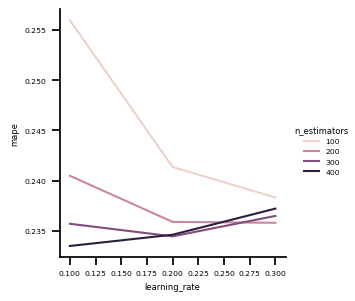

In [98]:
# Analyze grid search results
gs_results = fitted_grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.set_context("notebook", font_scale=0.5)
sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line", height=3)

plt.show()

Get the mape using the `mean_absolute_percentage_error`function and do some plotting.

Mean absolute percentage error: 0.20796876339386866


,LIFE_TIME_VALUE,LIFE_TIME_VALUE_PREDICTION
0,626.940002,625.523560
1,705.590027,703.990112
2,501.880005,457.369965
3,512.190002,460.805573
4,116.019997,112.999229
5,636.789978,636.572815
6,321.910004,313.977997
7,617.140015,616.768066
8,163.800003,157.148895
9,234.240005,235.725052


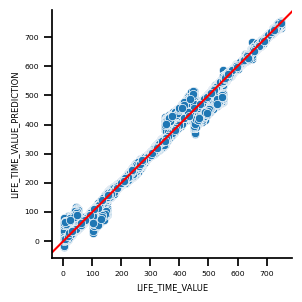

In [100]:
# Predict LTV for customers in test data
test_pre_df = pre_pipeline.transform(test_df)
test_predictions = fitted_grid_search.predict(test_pre_df).cache_result()


# Analyze results
mape = mean_absolute_percentage_error(df=test_predictions, 
                                        y_true_col_names="LIFE_TIME_VALUE", 
                                        y_pred_col_names="LIFE_TIME_VALUE_PREDICTION")


# Plot actual vs predicted 
g = sns.relplot(
    data=test_predictions["LIFE_TIME_VALUE", "LIFE_TIME_VALUE_PREDICTION"].to_pandas().astype("float64"), 
    x="LIFE_TIME_VALUE", 
    y="LIFE_TIME_VALUE_PREDICTION", 
    kind="scatter",
    height=3)
g.ax.axline((0,0), slope=1, color="r")

col1, col2 = st.columns(2)
with col1:
    print(f"Mean absolute percentage error: {mape}")
    st.dataframe(test_predictions.select("LIFE_TIME_VALUE", "LIFE_TIME_VALUE_PREDICTION").limit(15))
with col2:
    plt.show()

We will save the predictions with the actuals to use as the baseline for the model monitor we will create later in another notebook.

In [ ]:
# Save the predictions as a table to be used as a baseline for our model monitor
train_predictions = fitted_grid_search.predict(train_pre_df) 
baseline_df = train_predictions.with_column("PREDICTION_TIMESTAMP", snow_funcs.to_timestamp(snow_funcs.lit("2024-11-26"), snow_funcs.lit("YYYY-MM-DD")))

baseline_df.write.save_as_table("CUSTOMER_LTV_BASELINE", mode="overwrite")
session.table("CUSTOMER_LTV_BASELINE").show()

Save the fitted pre_pipeline to a stage so we can use it later for inference.

In [ ]:
# Save the preprocessing pipeline to be used later
file_path = f"@{stage_name}/pre_processing.joblib"
input_stream = io.BytesIO()
joblib.dump(pre_pipeline, input_stream)
session.file.put_stream(input_stream, file_path, auto_compress=False, overwrite=True)


Check that the file is in our stage

In [ ]:
ls @assets

We will only log the best model, this is also due to that SHAP does not support GridSearchCV objects, so we add that to a new variable and also get the number of estimators and learning rate values used to train it.

In [ ]:
# We will only log the best model
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate

Connect to the Model Registry schema

In [104]:
# Create reference to model registry
ml_reg = Registry(session=session, database_name=db_name, schema_name=mr_schema_name, options={"enable_monitoring": True})
ml_reg.show_models()

""


Log the model to the model Registry.

In [105]:

# Register new model version
registered_model = ml_reg.log_model(
    optimal_model,
    model_name="CUSTOMER_LTV_MODEL",
    #version_name='MY_SECOND_MODEL_VERSION', # We can set the version name or get a generated name
    comment="Model trained using GridsearchCV in Snowpark to predict Customer Life Time Value",
    metrics={"mean_abs_pct_err": mape
            , "n_estimators": optimal_n_estimators
            , "learning_rate":optimal_learning_rate},
    sample_input_data=train_pre_df.select(feature_cols),
    conda_dependencies=['xgboost'],
    options={'relax_version': False}
)

/Users/mstellwall/anaconda3/envs/notebooks_39/lib/python3.9/contextlib.py:119: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)


Check that we now have a registred model and the version name of it

In [106]:
ml_reg.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2024-09-12 04:25:51.307000-07:00,CUSTOMER_LTV_MODEL,USER_MODEL,SNOWPARK_DEMO_DB,SIMPLE_MR_SCHEMA,None,SYSADMIN,MY_FIRST_MODEL_VERSION,"[""MY_FIRST_MODEL_VERSION""]","{""DEFAULT"":""MY_FIRST_MODEL_VERSION"",""FIRST"":""M..."


In [ ]:
registered_model.version_name

Every model will have a default version and we can check on the model level the version name of the default model

In [ ]:
ml_reg.get_model("CUSTOMER_LTV_MODEL").default

If we want to change the default version of a model we can use for example `ml_reg.get_model("CUSTOMER_LTV_MODEL").default = 'ODD_DUCK_2'`, there is also other methods to manage model life cycle and default versions etc, see https://docs.snowflake.com/en/developer-guide/snowflake-ml/model-registry/model-management for more information.

Check what functions we can use with the new model version.

In [ ]:
registered_model.show_functions()

## Model Explianability

We can use the `explain` function to get the SHAP values.

In [ ]:
mv_explanations = registered_model.run(train_pre_df, function_name="explain")
mv_explanations.show()

It is then possible to use the standard SHAP library to for example visulize

In [ ]:
mv_explanations_pd = mv_explanations.to_pandas()

mv_explanations_pd_2 = mv_explanations_pd[['GENDER_OHE_FEMALE_explanation',
                                           'GENDER_OHE_MALE_explanation',
                                           'MEMBERSHIP_STATUS_OE_explanation',
                                           'MEMBERSHIP_LENGTH_DAYS_explanation',
                                           'AVG_SESSION_LENGTH_MIN_IMP_explanation',
                                           'AVG_TIME_ON_APP_MIN_IMP_explanation',
                                           'AVG_TIME_ON_WEBSITE_MIN_IMP_explanation',
                                           'APP_PRIMARY_explanation']]

# Wrapping the explanations DataFrame into a SHAP recognized object
shap_exp = shap._explanation.Explanation(mv_explanations_pd_2.values, 
                                         feature_names = mv_explanations_pd_2.columns)
shap.plots.bar(shap_exp)

## Model Linage

Using the model view linage will give us the direct linage.

In [108]:
registered_model.lineage('upstream')

[Dataset(
   name='SNOWPARK_DEMO_DB.SIMPLE_FS_SCHEMA.ECOMMERCE_CUSTOMER_FEATURES',
   version='2024_09_12_13_15_12',
 )]

By using Snowpark `lineage.trace` we can get more obejcts, and we can plot that (using a custom plotting function in the plotting.py file). We can also get the same level of details in Snowsight when we look at the model version there.

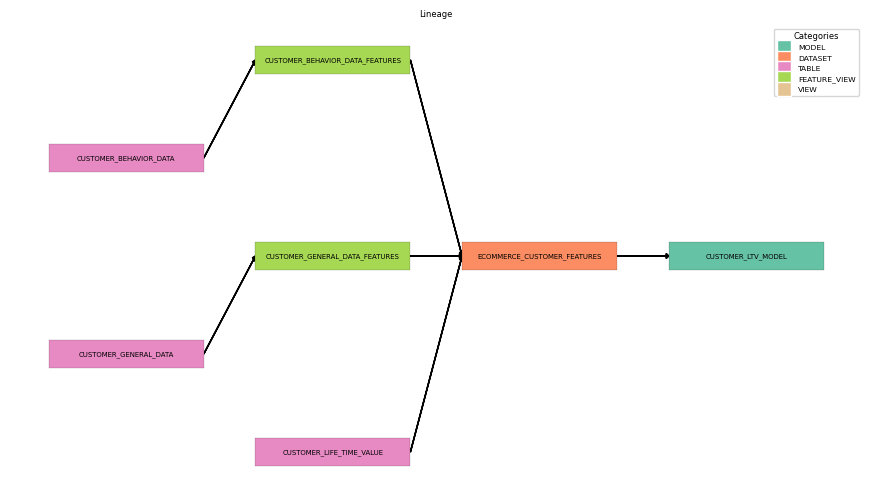

In [109]:
df = session.lineage.trace(f"{db_name}.{mr_schema_name}.CUSTOMER_LTV_MODEL", "MODEL", object_version=registered_model.version_name, direction='upstream', distance=3)
plot_lineage(df)